# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1-oracle.run2",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_44', 'ORACLE.run1_50', 'ORACLE.run1_8', 'ORACLE.run1_32', 'ORACLE.run1_20', 'ORACLE.run1_26', 'ORACLE.run1_38', 'ORACLE.run1_14'}


{'ORACLE.run2_8', 'ORACLE.run2_50', 'ORACLE.run2_26', 'ORACLE.run2_44', 'ORACLE.run2_14', 'ORACLE.run2_38', 'ORACLE.run2_20', 'ORACLE.run2_32'}


tensor([[[-1.3566,  0.4052, -0.1762,  ...,  0.8985, -0.0705, -0.3700],
         [-0.3700,  0.7223,  0.0529,  ...,  1.6913,  0.2995,  1.2861]],

        [[-0.0513,  1.4358, -0.1538,  ..., -0.8205, -0.4444,  0.6324],
         [ 0.3931, -2.0169, -1.2136,  ...,  0.1026, -1.0939,  0.8205]],

        [[ 0.3392,  0.2500, -0.1964,  ...,  0.2857,  0.1785, -0.2143],
         [-1.1606, -1.2141,  0.6071,  ...,  0.0536,  0.2321,  0.1250]],

        ...,

        [[ 1.2825, -0.1789,  0.4175,  ..., -0.9842, -0.1193,  1.2228],
         [ 0.2088,  1.7149,  0.1491,  ...,  0.3430, -0.4921, -1.1035]],

        [[ 0.6304, -0.7204, -0.2101,  ...,  0.3002,  0.3452,  0.1051],
         [ 0.4352, -1.0206,  0.6604,  ..., -1.6509, -0.8705,  0.1051]],

        [[ 0.8216,  0.6872, -0.6274,  ...,  0.5079,  0.5079,  0.9560],
         [-0.0896, -0.4930, -0.2988,  ...,  0.1344, -0.0149, -0.4183]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 9.9249, train_label_loss: 2.8086, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 3213.9870, train_label_loss: 1.4513, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 3216.6848, train_label_loss: 0.6406, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 3208.4297, train_label_loss: 1.8074, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 3201.4569, train_label_loss: 1.0780, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 3212.7580, train_label_loss: 0.6909, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 3212.3286, train_label_loss: 0.9168, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 3203.7333, train_label_loss: 1.1123, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 3202.6338, train_label_loss: 0.4342, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 3211.7270, train_label_loss: 0.6026, 


epoch: 1, source_val_acc_label: 0.6430, target_val_acc_label: 0.6282, source_val_label_loss: 0.9503, target_val_label_loss: 0.9971, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 0.9646, train_label_loss: 1.3138, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 3225.3338, train_label_loss: 0.7444, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 3243.3408, train_label_loss: 1.1228, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 3245.5984, train_label_loss: 0.8054, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 3235.8066, train_label_loss: 0.7031, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 3249.0389, train_label_loss: 0.8551, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3242.5676, train_label_loss: 0.5658, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 3232.0676, train_label_loss: 0.4995, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 3241.9482, train_label_loss: 1.3966, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 3244.0754, train_label_loss: 0.5194, 


epoch: 2, source_val_acc_label: 0.6673, target_val_acc_label: 0.6469, source_val_label_loss: 0.8813, target_val_label_loss: 0.9443, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.9698, train_label_loss: 0.5773, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 3225.5029, train_label_loss: 0.4679, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 3238.9984, train_label_loss: 1.1706, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 3246.5581, train_label_loss: 0.6377, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 3233.4228, train_label_loss: 0.6765, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 3242.4790, train_label_loss: 0.8431, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 3243.2550, train_label_loss: 0.6109, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 3230.9680, train_label_loss: 1.0130, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 3238.8705, train_label_loss: 0.6716, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 3239.4101, train_label_loss: 1.0033, 


epoch: 3, source_val_acc_label: 0.6954, target_val_acc_label: 0.6757, source_val_label_loss: 0.8124, target_val_label_loss: 0.8869, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.9695, train_label_loss: 1.0075, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 3225.4292, train_label_loss: 0.5202, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 3239.7442, train_label_loss: 0.8800, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 3242.8421, train_label_loss: 0.3577, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 3231.9166, train_label_loss: 0.6579, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 3241.7661, train_label_loss: 0.6720, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 3243.5302, train_label_loss: 0.7935, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 3222.6242, train_label_loss: 0.9173, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 3242.4357, train_label_loss: 0.2888, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3230.7158, train_label_loss: 0.5221, 


epoch: 4, source_val_acc_label: 0.7132, target_val_acc_label: 0.6954, source_val_label_loss: 0.7786, target_val_label_loss: 0.8609, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.9676, train_label_loss: 0.5869, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 3229.2025, train_label_loss: 0.5063, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 3241.0188, train_label_loss: 0.4587, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 3243.2976, train_label_loss: 0.8086, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 3236.4198, train_label_loss: 0.5739, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 3245.7581, train_label_loss: 0.8918, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 3247.3139, train_label_loss: 0.5873, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 3235.6281, train_label_loss: 0.5471, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 3233.7542, train_label_loss: 0.5579, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 3236.4067, train_label_loss: 0.2422, 


epoch: 5, source_val_acc_label: 0.7161, target_val_acc_label: 0.6963, source_val_label_loss: 0.7730, target_val_label_loss: 0.8552, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.9700, train_label_loss: 0.2953, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 3220.7995, train_label_loss: 0.7431, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 3238.7939, train_label_loss: 0.6153, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 3242.3003, train_label_loss: 0.6177, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 3224.8600, train_label_loss: 0.4703, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 3240.8143, train_label_loss: 0.3904, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 3241.9581, train_label_loss: 0.6416, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 3231.6765, train_label_loss: 0.2928, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 3244.6353, train_label_loss: 0.8177, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 3234.0901, train_label_loss: 0.9587, 


epoch: 6, source_val_acc_label: 0.7264, target_val_acc_label: 0.7118, source_val_label_loss: 0.7542, target_val_label_loss: 0.8309, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.9668, train_label_loss: 0.4771, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 3225.9389, train_label_loss: 0.2669, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 3240.6057, train_label_loss: 0.4102, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 3238.7948, train_label_loss: 0.7246, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 3229.6378, train_label_loss: 0.2729, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 3247.2839, train_label_loss: 0.6561, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 3246.0308, train_label_loss: 0.5758, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 3233.9051, train_label_loss: 0.7546, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 3240.3765, train_label_loss: 0.5674, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 3238.7354, train_label_loss: 0.5566, 


epoch: 7, source_val_acc_label: 0.7324, target_val_acc_label: 0.7170, source_val_label_loss: 0.7551, target_val_label_loss: 0.8325, 


New best


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.9662, train_label_loss: 0.2841, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 3208.4929, train_label_loss: 0.3539, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 3239.6670, train_label_loss: 0.1365, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 3245.6255, train_label_loss: 0.2943, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 3226.6775, train_label_loss: 0.3815, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 3234.9753, train_label_loss: 0.4054, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 3240.9552, train_label_loss: 0.4121, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 3236.2645, train_label_loss: 0.1497, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 3222.4078, train_label_loss: 0.2685, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 3249.8223, train_label_loss: 0.1560, 


epoch: 8, source_val_acc_label: 0.7333, target_val_acc_label: 0.7172, source_val_label_loss: 0.7566, target_val_label_loss: 0.8379, 


New best


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.9683, train_label_loss: 0.2474, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 3222.3295, train_label_loss: 0.4143, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 3241.2989, train_label_loss: 0.4713, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 3245.9282, train_label_loss: 0.2669, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 3230.8385, train_label_loss: 0.4821, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 3240.8563, train_label_loss: 0.4143, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 3237.1124, train_label_loss: 0.1544, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 3232.9392, train_label_loss: 0.3603, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 3243.1320, train_label_loss: 0.5076, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 3242.7978, train_label_loss: 0.5600, 


epoch: 9, source_val_acc_label: 0.7334, target_val_acc_label: 0.7175, source_val_label_loss: 0.7725, target_val_label_loss: 0.8557, 


New best


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.9650, train_label_loss: 0.3142, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 3226.8029, train_label_loss: 0.3451, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 3234.8448, train_label_loss: 0.6794, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3243.3497, train_label_loss: 0.3485, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3240.0250, train_label_loss: 0.6359, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3248.0947, train_label_loss: 0.1999, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3246.2246, train_label_loss: 0.4553, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 3242.2768, train_label_loss: 0.4811, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 3230.4492, train_label_loss: 0.2654, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 3244.2101, train_label_loss: 0.6330, 


epoch: 10, source_val_acc_label: 0.7315, target_val_acc_label: 0.7164, source_val_label_loss: 0.7891, target_val_label_loss: 0.8708, 


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.9709, train_label_loss: 0.4489, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 3226.0502, train_label_loss: 0.6387, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 3237.3712, train_label_loss: 0.1922, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 3245.5040, train_label_loss: 0.2913, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 3238.7288, train_label_loss: 0.2047, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 3238.0670, train_label_loss: 0.4466, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 3243.0573, train_label_loss: 0.4803, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 3234.0878, train_label_loss: 0.6263, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 3237.1763, train_label_loss: 0.4807, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 3234.0687, train_label_loss: 0.5203, 


epoch: 11, source_val_acc_label: 0.7280, target_val_acc_label: 0.7111, source_val_label_loss: 0.8184, target_val_label_loss: 0.9021, 


epoch: 12, [batch: 1 / 33600], examples_per_second: 0.9659, train_label_loss: 0.5023, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 3226.8157, train_label_loss: 0.2096, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 3240.6042, train_label_loss: 0.2313, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 3247.7423, train_label_loss: 0.2648, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 3231.3671, train_label_loss: 0.2357, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 3249.5248, train_label_loss: 0.1623, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 3239.9180, train_label_loss: 0.2910, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 3227.6844, train_label_loss: 0.0690, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 3221.5873, train_label_loss: 0.3304, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 3247.7566, train_label_loss: 0.5904, 


epoch: 12, source_val_acc_label: 0.7244, target_val_acc_label: 0.7064, source_val_label_loss: 0.8358, target_val_label_loss: 0.9247, 


epoch: 13, [batch: 1 / 33600], examples_per_second: 0.9703, train_label_loss: 0.3277, 


epoch: 13, [batch: 3360 / 33600], examples_per_second: 3221.2092, train_label_loss: 0.7161, 


epoch: 13, [batch: 6720 / 33600], examples_per_second: 3233.9191, train_label_loss: 0.2012, 


epoch: 13, [batch: 10080 / 33600], examples_per_second: 3245.3954, train_label_loss: 0.0382, 


epoch: 13, [batch: 13440 / 33600], examples_per_second: 3225.0573, train_label_loss: 0.3457, 


epoch: 13, [batch: 16800 / 33600], examples_per_second: 3244.9846, train_label_loss: 0.2570, 


epoch: 13, [batch: 20160 / 33600], examples_per_second: 3245.7885, train_label_loss: 0.6347, 


epoch: 13, [batch: 23520 / 33600], examples_per_second: 3229.9047, train_label_loss: 0.1419, 


epoch: 13, [batch: 26880 / 33600], examples_per_second: 3243.2285, train_label_loss: 0.2974, 


epoch: 13, [batch: 30240 / 33600], examples_per_second: 3246.9127, train_label_loss: 0.0837, 


epoch: 13, source_val_acc_label: 0.7229, target_val_acc_label: 0.7070, source_val_label_loss: 0.8552, target_val_label_loss: 0.9450, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

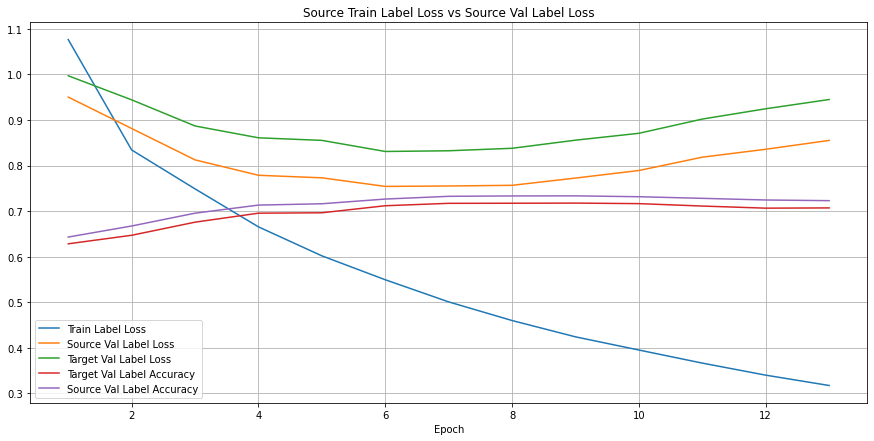

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

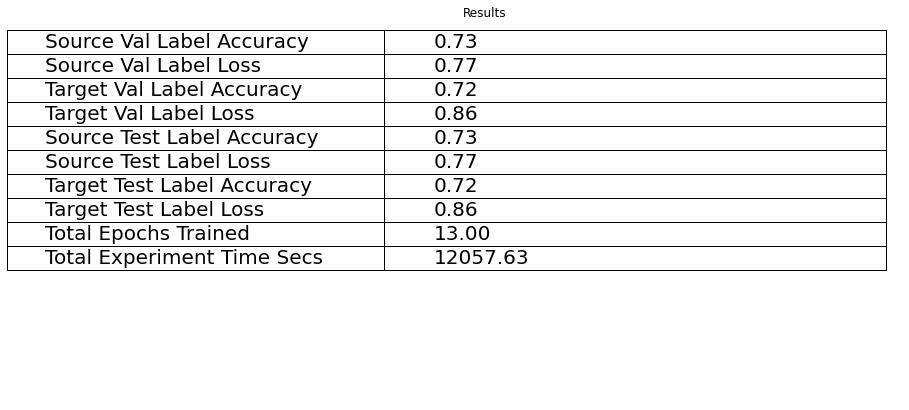

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

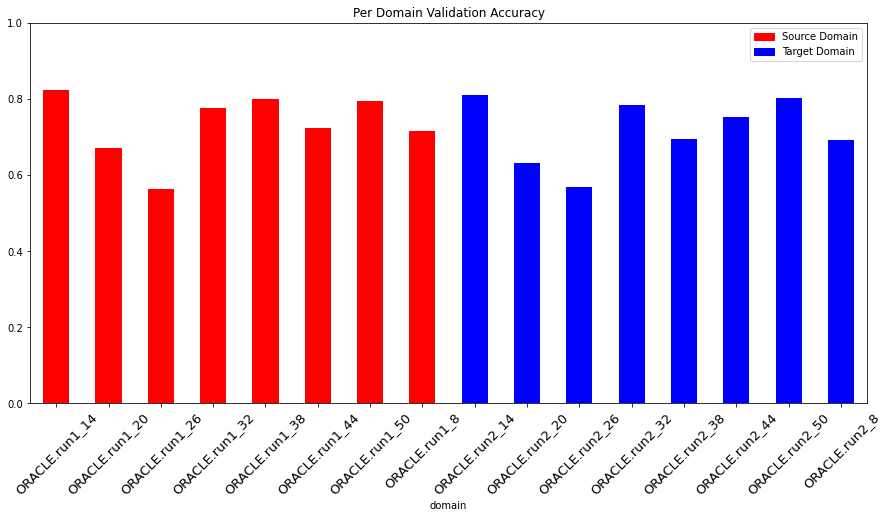

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7337434895833334 Target Test Label Accuracy: 0.7158854166666667
Source Val Label Accuracy: 0.7334309895833333 Target Val Label Accuracy: 0.7175455729166667


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1-oracle.run2", "parameters": {"experiment_name": "tl_1v2:oracle.run1-oracle.run2", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"